In [21]:
%matplotlib inline
from pomegranate import *
import matplotlib.pyplot as plt
import numpy as np
import copy

In [29]:
"""-> Znajdywanie wysp CG, wysp które składają się głównie z C i G.
   -> Są dwa stany "background" i "island.
   -> Są cztery obserwacje: A, C, G i T.
   -> d1 i d2 opisują dyskretny rozkład prawdopodobieństwa obserwacji
   dla stanów s1 i s2.
   -> Początkowe prawdopodobieństwo dla obu stanów jest równe 0.5
   -> Prawdopodobieństwo przejścia pomiędzy dowolnymi stanami jest 0.5.
   -> Wartość 1 oznacza background, a wartość 1 oznacza wyspę."""

seq = list('CGACTACTGACTACTCGCCGACGCGACTGCCGTCTATACTGCGCATACGGC')

d1 = DiscreteDistribution({'A': 0.25, 'C': 0.25, 'G': 0.25, 'T': 0.25})
d2 = DiscreteDistribution({'A': 0.10, 'C': 0.40, 'G': 0.40, 'T': 0.10})

s1 = State( d1, name='background' )
s2 = State( d2, name='island' )

hmm = HiddenMarkovModel()
hmm.add_states(s1, s2)
hmm.add_transition( hmm.start, s1, 0.5 )
hmm.add_transition( hmm.start, s2, 0.5 )
hmm.add_transition( s1, s1, 0.5 )
hmm.add_transition( s1, s2, 0.5 )
hmm.add_transition( s2, s1, 0.5 )
hmm.add_transition( s2, s2, 0.5 )
hmm.bake()

hmm_predictions = hmm.predict( seq )
print "sequence: {}".format( ''.join( seq ) )
print "hmm pred: {}".format( ''.join( map( str, hmm_predictions ) ) )


sequence: CGACTACTGACTACTCGCCGACGCGACTGCCGTCTATACTGCGCATACGGC
hmm pred: 001011010101101000001000010100001011110100001110000


In [14]:
"""-> Zmienione prawdopodobieństwo przejścia pomiędzy stanami.
      Teraz zmiana stanu na inny jest mało prawdopodobna."""
hmm = HiddenMarkovModel()
hmm.add_states(s1, s2)
hmm.add_transition( hmm.start, s1, 0.5 )
hmm.add_transition( hmm.start, s2, 0.5 )
hmm.add_transition( s1, s1, 0.9 )
hmm.add_transition( s1, s2, 0.1 )
hmm.add_transition( s2, s1, 0.1 )
hmm.add_transition( s2, s2, 0.9 )
hmm.bake()

hmm_predictions = hmm.predict( seq )
print "sequence: {}".format( ''.join( seq ) )
print "hmm pred: {}".format( ''.join( map( str, hmm_predictions ) ) )

sequence: CGACTACTGACTACTCGCCGACGCGACTGCCGTCTATACTGCGCATACGGC
hmm pred: 111111111111111000000000000000011111111111111110000


In [15]:
"""-> Dodany stan końcowy, do którego można dotrzeć tylko z s1."""

hmm = HiddenMarkovModel()
hmm.add_states(s1, s2)
hmm.add_transition( hmm.start, s1, 0.5 )
hmm.add_transition( hmm.start, s2, 0.5 )
hmm.add_transition( s1, s1, 0.89 )
hmm.add_transition( s1, s2, 0.10 )
hmm.add_transition( s1, hmm.end, 0.01 )
hmm.add_transition( s2, s1, 0.1 )
hmm.add_transition( s2, s2, 0.9 )
hmm.bake()

hmm_predictions = hmm.predict( seq )
print "sequence: {}".format( ''.join( seq ) )
print "hmm pred: {}".format( ''.join( map( str, hmm_predictions ) ) )

sequence: CGACTACTGACTACTCGCCGACGCGACTGCCGTCTATACTGCGCATACGGC
hmm pred: 111111111111111000000000000000011111111111111111111


In [ ]:
"""-> Obliczone prawdopodobieństwa dla każdej z obserwacji w każdym
      ze stanow."""

print hmm.predict_proba( seq )

In [16]:
"""-> Standardowa implementacja hmm.predict używa forward-backward 
      w połączeniu z maximum a posteriori do dekodowania.
   -> Poniżej próba z użyciem algorytmu Viterbi."""

hmm_predictions = hmm.predict( seq, algorithm='viterbi' )[1:-1]

print "sequence: {}".format( ''.join( seq ) )
print "hmm pred: {}".format( ''.join( map( str, hmm_predictions ) ) )

sequence: CGACTACTGACTACTCGCCGACGCGACTGCCGTCTATACTGCGCATACGGC
hmm pred: 111111111111111111111111111111111111111111111111111


In [8]:
"""-> odnajdowanie sekwencji.
      w poniższym przykładzie szukamy sekwencji ACT.
   -> Są trzy stany odpowiedzialne za kolejno: A, C, T.
      Dla tych samych prawdopodobieństwo emisji odpowiednich stanów
      jest bardzo duże.
   -> Są dodatkowe "insert states", które pozwalają zapewnić
      inserty w sekwencji (niepasujące elementy w środku).
      Inserty mogą wygenerować dowolną obserwację równym
      prawdopodobieństwe. Inserty mogą być na początku, na końcu lub
      w środku.
   -> Dodatkowo są też "delete states" opisujące brak jakiegoś
      elementu sekwencji. Delete states nie generują żadnej obserwacji.
      """

model = HiddenMarkovModel( "Global Alignment")

# Define the distribution for insertions
i_d = DiscreteDistribution( { 'A': 0.25, 'C': 0.25, 'G': 0.25, 'T': 0.25 } )

# Create the insert states
i0 = State( i_d, name="I0" )
i1 = State( i_d, name="I1" )
i2 = State( i_d, name="I2" )
i3 = State( i_d, name="I3" )

# Create the match states
m1 = State( DiscreteDistribution({ "A": 0.95, 'C': 0.01, 'G': 0.01, 'T': 0.02 }) , name="M1" )
m2 = State( DiscreteDistribution({ "A": 0.003, 'C': 0.99, 'G': 0.003, 'T': 0.004 }) , name="M2" )
m3 = State( DiscreteDistribution({ "A": 0.01, 'C': 0.01, 'G': 0.01, 'T': 0.97 }) , name="M3" )

# Create the delete states
d1 = State( None, name="D1" )
d2 = State( None, name="D2" )
d3 = State( None, name="D3" )

# Add all the states to the model
model.add_states( [i0, i1, i2, i3, m1, m2, m3, d1, d2, d3 ] )


# Create transitions from match states
model.add_transition( model.start, m1, 0.9 )
model.add_transition( model.start, i0, 0.1 )
model.add_transition( m1, m2, 0.9 )
model.add_transition( m1, i1, 0.05 )
model.add_transition( m1, d2, 0.05 )
model.add_transition( m2, m3, 0.9 )
model.add_transition( m2, i2, 0.05 )
model.add_transition( m2, d3, 0.05 )
model.add_transition( m3, model.end, 0.9 )
model.add_transition( m3, i3, 0.1 )


# Create transitions from insert states
model.add_transition( i0, i0, 0.70 )
model.add_transition( i0, d1, 0.15 )
model.add_transition( i0, m1, 0.15 )

model.add_transition( i1, i1, 0.70 )
model.add_transition( i1, d2, 0.15 )
model.add_transition( i1, m2, 0.15 )

model.add_transition( i2, i2, 0.70 )
model.add_transition( i2, d3, 0.15 )
model.add_transition( i2, m3, 0.15 )

model.add_transition( i3, i3, 0.85 )
model.add_transition( i3, model.end, 0.15 )

# Create transitions from delete states
model.add_transition( d1, d2, 0.15 )
model.add_transition( d1, i1, 0.15 )
model.add_transition( d1, m2, 0.70 ) 

model.add_transition( d2, d3, 0.15 )
model.add_transition( d2, i2, 0.15 )
model.add_transition( d2, m3, 0.70 )

model.add_transition( d3, i3, 0.30 )
model.add_transition( d3, model.end, 0.70 )

# Call bake to finalize the structure of the model.
model.bake()

def path_to_alignment(x, y, path):
    for i, (index, state) in enumerate(path[1:-1]):
        if state.name.startswith('D'):
            y = y[:i] + '-' + y[i:]
        elif state.name.startswith('I'):
            x = x[:i] + '-' + x[i:]
    return x, y

for sequence in map( list, ('A', 'GA', 'AC', 'AT', 'ATCC', 'ACGTG', 'ATTT', 'TACCCTC', 'TGTCAACACT') ):
    logp, path = model.viterbi( sequence )
    print "\n".join(path_to_alignment('ACT', ''.join(sequence), path))
    print "Sequence: '{}'  -- Log Probability: {} -- Path: {}".format(
        ''.join( sequence ), logp, " ".join( state.name for idx, state in path[1:-1] ) )

ACT
A--
Sequence: 'A'  -- Log Probability: -5.40618101242 -- Path: M1 D2 D3
-ACT
GA--
Sequence: 'GA'  -- Log Probability: -10.8868199358 -- Path: I0 M1 D2 D3
ACT
AC-
Sequence: 'AC'  -- Log Probability: -3.62447187905 -- Path: M1 M2 D3
ACT
A-T
Sequence: 'AT'  -- Log Probability: -3.64488075068 -- Path: M1 D2 M3
ACT--
A-TCC
Sequence: 'ATCC'  -- Log Probability: -10.6743329646 -- Path: M1 D2 M3 I3 I3
AC---T
ACGTG-
Sequence: 'ACGTG'  -- Log Probability: -10.3938248352 -- Path: M1 M2 I2 I2 I2 D3
A--CT
ATT-T
Sequence: 'ATTT'  -- Log Probability: -8.67126440175 -- Path: M1 I1 I1 D2 M3
----ACT-
TACC-CTC
Sequence: 'TACCCTC'  -- Log Probability: -16.9034517961 -- Path: I0 I0 I0 I0 D1 M2 M3 I3
-------ACT
TGTCAACACT
Sequence: 'TGTCAACACT'  -- Log Probability: -16.4516996541 -- Path: I0 I0 I0 I0 I0 I0 I0 M1 M2 M3


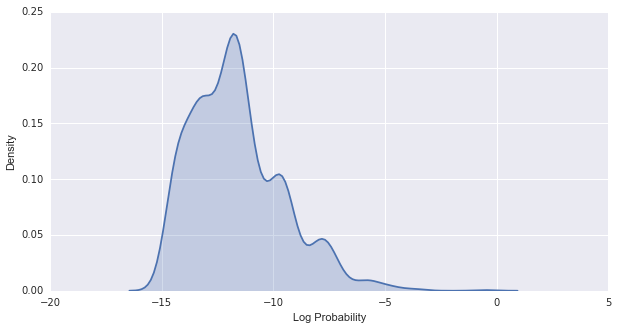

In [9]:
sequences = reduce( lambda x, y: x+y, [[ seq for seq in it.product( 'ACGT', repeat=i ) ] for i in xrange( 1,6 )] )
scores = map( model.log_probability, sequences )

import itertools
import seaborn as sns
plt.figure( figsize=(10,5) )
sns.kdeplot( numpy.array( scores ), shade=True )
plt.ylabel('Density')
plt.xlabel('Log Probability')
plt.show()

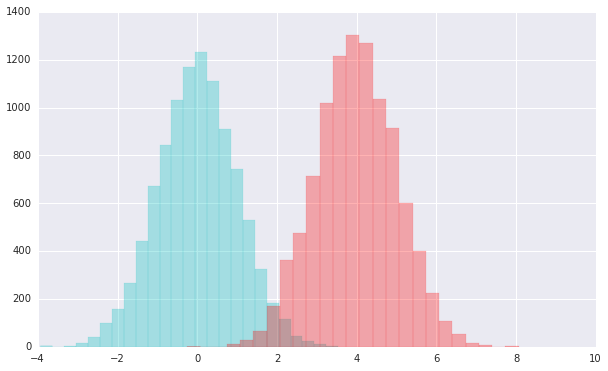

In [11]:
d1 = NormalDistribution( 0, 1 )
d2 = NormalDistribution( 4, 1 )
plt.figure( figsize=(10,6) )
d1.plot( n=10000, edgecolor='c', facecolor='c', alpha=0.3, bins=25 )
d2.plot( n=10000, edgecolor='r', facecolor='r', alpha=0.3, bins=25 )

In [20]:
d1 = DiscreteDistribution({'A' : 0.8, 'B' : 0.2})
d2 = DiscreteDistribution({'A' : 0.2, 'B' : 0.8})

s1 = State(d1, name="NotTied1" )
s2 = State(d2, name="NotTied2" )

model = HiddenMarkovModel()
model.add_states( [s1, s2] )

model.add_transition( model.start, s1, 0.5 )
model.add_transition( model.start, s2, 0.5 )

model.add_transition( s1, s1, 0.9 )
model.add_transition( s1, s2, 0.1 )
model.add_transition( s2, s1, 0.1 )
model.add_transition( s2, s2, 0.9 )
model.bake()


corpus_good = [['A','A'],['B','B']]
print sum([model.log_probability(x) for x in corpus_good])

corpus_bad = [['A', 'B'],['B', 'A']]
print sum([model.log_probability(x) for x in corpus_bad])

print "="*50
model.train(copy.copy(corpus_good), verbose=False)
print "training"
print "="*50

corpus_good = [['A','A'],['B','B']]
print sum([model.log_probability(x) for x in corpus_good])

corpus_bad = [['A', 'B'],['B', 'A']]
print sum([model.log_probability(x) for x in corpus_bad])

-2.26640746688
-3.45194345738
training
-1.38629436112
-122.281510582


In [46]:
d1 = DiscreteDistribution({'A' : 0.8, 'B' : 0.1, 'C' : 0.1})
d2 = DiscreteDistribution({'A' : 0.1, 'B' : 0.8, 'C' : 0.1})
d3 = DiscreteDistribution({'A' : 0.1, 'B' : 0.1, 'C' : 0.8})

s1 = State(d1, name="S1" )
s2 = State(d2, name="S2" )
s3 = State(d3, name="S3" )

model = HiddenMarkovModel()
model.add_states( [s1, s2, s3] )

model.add_transition( model.start, s1, 0.33 )
model.add_transition( model.start, s2, 0.33 )
model.add_transition( model.start, s3, 0.34 )

model.add_transition( s1, s1, 0.33 )
model.add_transition( s1, s2, 0.33 )
model.add_transition( s1, s3, 0.34 )

model.add_transition( s2, s1, 0.33 )
model.add_transition( s2, s2, 0.33 )
model.add_transition( s2, s3, 0.34 )

model.add_transition( s3, s1, 0.33 )
model.add_transition( s3, s2, 0.33 )
model.add_transition( s3, s3, 0.34 )
model.bake()


corpus_train = [['A','A','A'],['A','B','B'],['A','B','C'],['A','B','C','C'],
                ['A','A','B'],['A','B','B','C'],['A','A','B','C'],['A','B','B','B'],
                ['A','A','B','B']]

corpus_good = [['A','A','B'],['A','B','C'],['A','B','B']]
print sum([model.log_probability(x) for x in corpus_good])

corpus_bad = [['B','A','A'],['B','A','C'],['C','B','A']]
print sum([model.log_probability(x) for x in corpus_bad])

print "="*50
model.train(copy.copy(corpus_train), distribution_inertia=0.3, edge_inertia=0.25)
print "training"
print "="*50


corpus_good = [['A','A','B'],['A','B','C'],['A','B','B']]
print sum([model.log_probability(x) for x in corpus_good])

corpus_bad = [['B','A','A'],['B','A','C'],['C','B','A']]
print sum([model.log_probability(x) for x in corpus_bad])

model.log_probability(['A','A','B','C','C','C'])

-9.92980461234
-9.90887709223
Training improvement: 9.08547455258
Training improvement: 4.72290179426
Training improvement: 3.21294023946
Training improvement: 1.77420578975
Training improvement: 0.816339667767
Training improvement: 0.362947634805
Training improvement: 0.170482139785
Training improvement: 0.0877473458804
Training improvement: 0.0500712675949
Training improvement: 0.0315347572964
Training improvement: 0.021595960397
Training improvement: 0.0157883388546
Training improvement: 0.0121170845838
Training improvement: 0.00963554789663
Training improvement: 0.0078639112217
Training improvement: 0.00654233826782
Training improvement: 0.00552123733415
Training improvement: 0.004709782841
Training improvement: 0.00405028760196
Training improvement: 0.00350466363799
Training improvement: 0.0030468770281
Training improvement: 0.00265855334006
Training improvement: 0.00232632700531
Training improvement: 0.00204019734747
Training improvement: 0.00179248472627
Training improvement: 0.

-2.2519494963931788

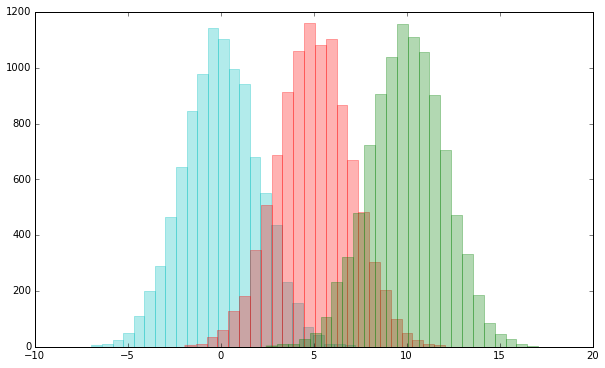

In [64]:
d1 = NormalDistribution( 0, 2 )
d2 = NormalDistribution( 5, 2 )
d3 = NormalDistribution( 10, 2 )

plt.figure( figsize=(10,6) )
d1.plot( n=10000, edgecolor='c', facecolor='c', alpha=0.3, bins=25 )
d2.plot( n=10000, edgecolor='r', facecolor='r', alpha=0.3, bins=25 )
d3.plot( n=10000, edgecolor='g', facecolor='g', alpha=0.3, bins=25 )

In [113]:
d1 = NormalDistribution( 0, 1 )
d2 = NormalDistribution( 5, 1 )
d3 = NormalDistribution( 10, 1 )

s1 = State(d1, name="S1" )
s2 = State(d2, name="S2" )
s3 = State(d3, name="S3" )

model = HiddenMarkovModel()
model.add_states( [s1, s2, s3] )

model.add_transition( model.start, s1, 0.33 )
model.add_transition( model.start, s2, 0.33 )
model.add_transition( model.start, s3, 0.34 )

model.add_transition( s1, s1, 0.33 )
model.add_transition( s1, s2, 0.33 )
model.add_transition( s1, s3, 0.34 )

model.add_transition( s2, s1, 0.33 )
model.add_transition( s2, s2, 0.33 )
model.add_transition( s2, s3, 0.34 )

model.add_transition( s3, s1, 0.33 )
model.add_transition( s3, s2, 0.33 )
model.add_transition( s3, s3, 0.34 )
model.bake()


corpus_good = [[1,5,10], [1,2,3]]
corpus_bad = [[10,5,1], [5,1,1]]
print sum([model.log_probability(x) for x in corpus_good])
print sum([model.log_probability(x) for x in corpus_bad])

print "="*50
corpus_train = []
for _ in xrange(1000):
    corpus_train.append(sorted(random.sample(range(0, 11), random.randint(2,10))))
model.train(corpus_train, verbose=False)
print "training"
print "="*50

print sum([model.log_probability(x) for x in corpus_good])
print sum([model.log_probability(x) for x in corpus_bad])


-16.9768574683
-13.6340764393
training
-10.7420958777
-35.8351453721


In [115]:
model.predict([1,2,3,4,5,6,7,8,9,10])

[0, 0, 2, 2, 2, 1, 1, 1, 1, 1]